# Multivariate Statistical Analysis of Air Pollution Drivers in the Philippines (2019–2024)
##Objective

This project investigates multivariate relationships among satellite-derived environmental indicators across the Philippines from 2019 to 2024. Specifically, we analyze the statistical relationships between:
- Tropospheric NO₂ (satellite-derived vertical column density)
- Aerosol Optical Depth (AOD)
- Land Surface Skin Temperature (SKT)
- Nighttime Lights (NTL)

The goal is to examine correlation structure, latent components (PCA), regime classification (clustering), predictive modeling (regression), and robustness across time.

Load Dataset

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

final_ds = xr.open_dataset("MASTER_PH_Pollution_2019_2024.nc")

final_ds

<xarray.Dataset> Size: 332MB
Dimensions:              (time: 73, Latitude: 658, Longitude: 432)
Coordinates:
  * time                 (time) datetime64[ns] 584B 2019-01-01 ... 2024-12-01
  * Latitude             (Latitude) float32 3kB 3.998 4.0 4.05 ... 21.0 21.07
  * Longitude            (Longitude) float32 2kB 116.0 116.0 ... 127.0 127.0
Data variables:
    Tropospheric_NO2     (time, Latitude, Longitude) float32 83MB ...
    COMBINE_AOD_550_AVG  (time, Latitude, Longitude) float32 83MB ...
    skt                  (time, Latitude, Longitude) float32 83MB ...
    NTL                  (time, Latitude, Longitude) float32 83MB ...
Attributes:
    long_name:      Tropospheric vertical column NO2 density
    units:          molec cm-2
    standard_name:  troposphere_mole_content_of_nitrogen_dioxide

#1. Data Description

The dataset consists of monthly observations from January 2019 to December 2024 across the Philippines. All variables were spatially harmonized to a common grid.

##Variables:

- Tropospheric_NO2 (molec cm⁻²)

- COMBINE_AOD_550_AVG

- skt (°C)

- NTL (nighttime radiance proxy)

Due to differences in satellite coverage and masking, large proportions of missing values were present after harmonization.

Check Structure

In [ ]:
final_ds.dims
final_ds.data_vars

Data variables:
    Tropospheric_NO2     (time, Latitude, Longitude) float32 83MB ...
    COMBINE_AOD_550_AVG  (time, Latitude, Longitude) float32 83MB ...
    skt                  (time, Latitude, Longitude) float32 83MB ...
    NTL                  (time, Latitude, Longitude) float32 83MB ...

Basic Statistics

In [ ]:
for var in final_ds.data_vars:
    print(var)
    print(final_ds[var].mean().values)
    print(final_ds[var].std().values)
    print(final_ds[var].min().values)
    print(final_ds[var].max().values)
    print("-----")

Tropospheric_NO2
560643052666880.0
268381517250560.0
-2090430913052672.0
9413217545617408.0
-----
COMBINE_AOD_550_AVG
0.1537589281797409
0.07850078493356705
-0.05000000074505806
3.5810000896453857
-----
skt
25.522790908813477
2.0761287212371826
15.293853759765625
35.672515869140625
-----
NTL
0.2573738396167755
0.6088960766792297
-0.32441774010658264
68.76747131347656
-----


## Missing Data

Check NaN Percent

In [ ]:
for var in final_ds.data_vars:
    nan_ratio = np.isnan(final_ds[var]).sum() / final_ds[var].size
    print(f"{var}: {float(nan_ratio)*100:.2f}% missing")

Tropospheric_NO2: 93.52% missing
COMBINE_AOD_550_AVG: 94.79% missing
skt: 98.96% missing
NTL: 91.86% missing


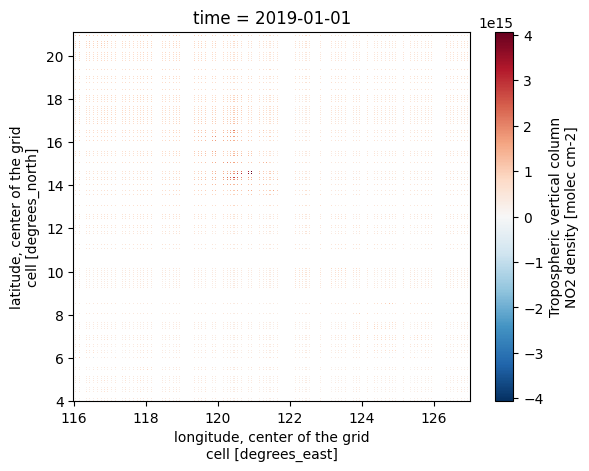

In [ ]:
final_ds['Tropospheric_NO2'].isel(time=0).plot()

#2. Data Preprocessing

The following steps were performed:

- Removal of extreme outliers using Z-score thresholding.

- Temporal interpolation along the monthly dimension.

- Log transformation of NO₂ (after clipping negative values).

- Z-score standardization for comparability across variables.

Due to high spatial sparsity after harmonization, analysis was primarily conducted at the national aggregate level rather than pixel-wise.

## Data Cleaning

Remove Extreme Outliers (Z > 5)

In [ ]:
def remove_outliers(da, threshold=5):
    z = (da - da.mean()) / da.std()
    return da.where(np.abs(z) < threshold)

clean_ds = final_ds.copy()

for var in clean_ds.data_vars:
    clean_ds[var] = remove_outliers(clean_ds[var])

Interpolate Missing Values (Time Dimension)

In [ ]:
clean_ds = clean_ds.interpolate_na(dim='time', method='linear')

Log Transform NO₂ (Highly Skewed)

In [ ]:
clean_ds['no2_log'] = np.log1p(clean_ds['Tropospheric_NO2'].clip(min=0))

## Standardization (Z-Score)

In [ ]:
standardized_ds = xr.Dataset()

for var in ['no2_log', 'COMBINE_AOD_550_AVG', 'skt', 'NTL']:
    mean = clean_ds[var].mean(dim='time')
    std = clean_ds[var].std(dim='time')
    standardized_ds[var + '_z'] = (clean_ds[var] - mean) / std

## National Mean Time Series

<Axes: xlabel='time'>

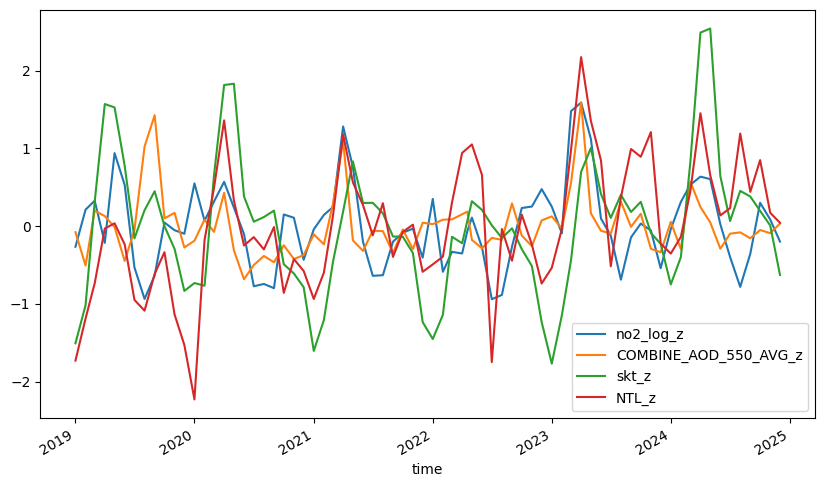

In [ ]:
national_mean = standardized_ds.mean(dim=['Latitude','Longitude'])

national_mean.to_dataframe().plot(figsize=(10,6))

#3. Exploratory Correlation Analysis

National-level monthly means were computed to improve signal-to-noise ratio. Pearson correlation coefficients were used to examine linear relationships among variables.

##Key Observations

- NO₂ shows moderate positive correlation with NTL.

- NO₂ shows moderate correlation with AOD.

- Temperature exhibits weaker direct correlation with NO₂.

- NTL and temperature exhibit notable positive association.

These relationships suggest partial coupling between anthropogenic activity proxies and pollution indicators.

##Pairwise Correlation (National Level)

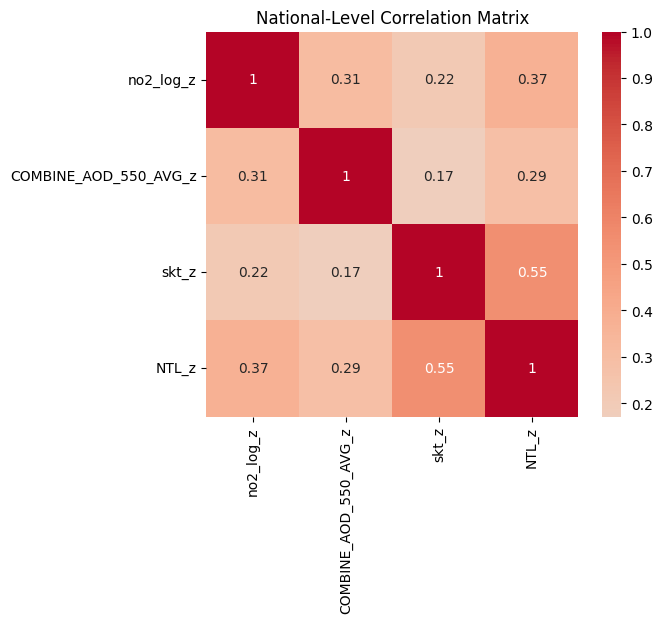

In [ ]:
df = national_mean.to_dataframe()

corr_matrix = df.corr(method='pearson')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("National-Level Correlation Matrix")
plt.show()

#4. Principal Component Analysis (PCA)

PCA was performed on standardized national monthly means to identify latent structures in the multivariate system.

##Results

- PC1 explains ~51% of total variance.

- PC2 explains ~23%.

- Remaining components contribute smaller fractions.

##Interpretation

- PC1 loads positively on NO₂, AOD, SKT, and NTL, representing a generalized pollution/activity intensity factor.

- PC2 reflects contrast between meteorological and emission-driven variability.

This indicates a dominant shared environmental variability component.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use national mean (already computed earlier)
national_mean = clean_ds[['no2_log','COMBINE_AOD_550_AVG','skt','NTL']].mean(
    dim=['Latitude','Longitude']
)

df = national_mean.to_dataframe()

# Drop any leftover NaNs
df = df.dropna()

# Standardize (important)
scaler = StandardScaler()
X = scaler.fit_transform(df)

# PCA
pca = PCA(n_components=4)
pca.fit(X)

print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

Explained variance ratio:
[0.5087729  0.2280342  0.16496284 0.09823011]


Scree Plot

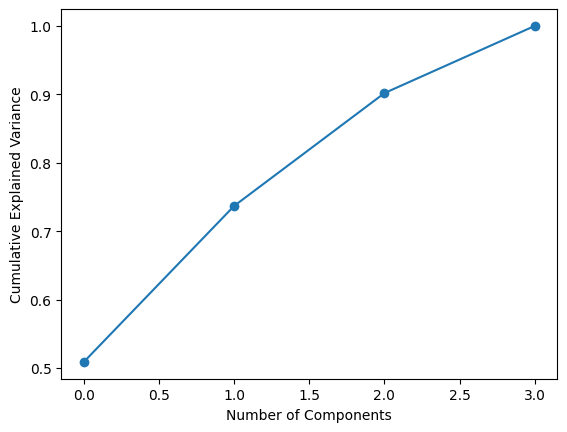

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

PCA Loadings

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(4)],
    index=['no2','aod','skt','ntl']
)

loadings

,PC1,PC2,PC3,PC4
no2,0.468029,-0.464301,0.712290,-0.240866
aod,0.435481,-0.569619,-0.690268,-0.097062
skt,0.494402,0.623564,-0.119173,-0.593745
ntl,0.588958,0.266697,0.044392,0.761597


#5. Emission Regime Classification (K-Means)

K-means clustering (k=3) was applied to standardized monthly means to identify distinct pollution regimes.

##Findings

Three statistically distinct regimes were identified (ANOVA p < 1e-10):

- Cluster 1: High NO₂, high NTL, high AOD — high emission regime.

- Cluster 0: Low across variables — low emission regime.

- Cluster 2: Moderate values — transitional regime.

These clusters represent statistically separable monthly environmental states.

In [ ]:
national_mean = standardized_ds.mean(dim=['Latitude','Longitude'])
df = national_mean.to_dataframe().dropna()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
scaler = StandardScaler()
X = scaler.fit_transform(df)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

df['cluster'] = labels


<Axes: xlabel='time'>

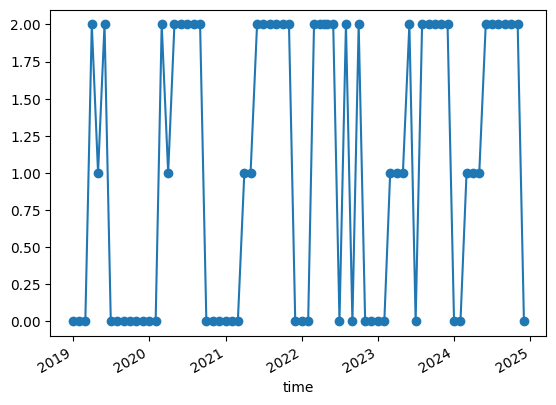

In [ ]:
df['cluster'].plot(marker='o')

## Inspect Clusters

In [ ]:
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=df.columns[:-1]  # exclude cluster column
)

centroids

,no2_log_z,COMBINE_AOD_550_AVG_z,skt_z,NTL_z
0,-0.072670,0.022955,-0.656730,-0.705956
1,0.950377,0.449211,1.146996,1.018887
2,-0.223002,-0.158098,0.249506,0.332938


Plot Variables by Cluster

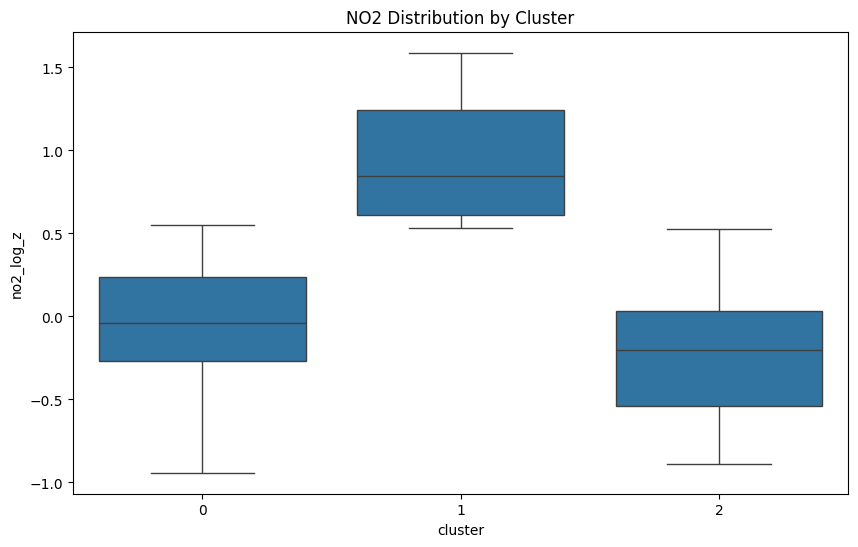

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df.reset_index()

plt.figure(figsize=(10,6))
sns.boxplot(data=df_plot, x='cluster', y='no2_log_z')
plt.title("NO2 Distribution by Cluster")
plt.show()

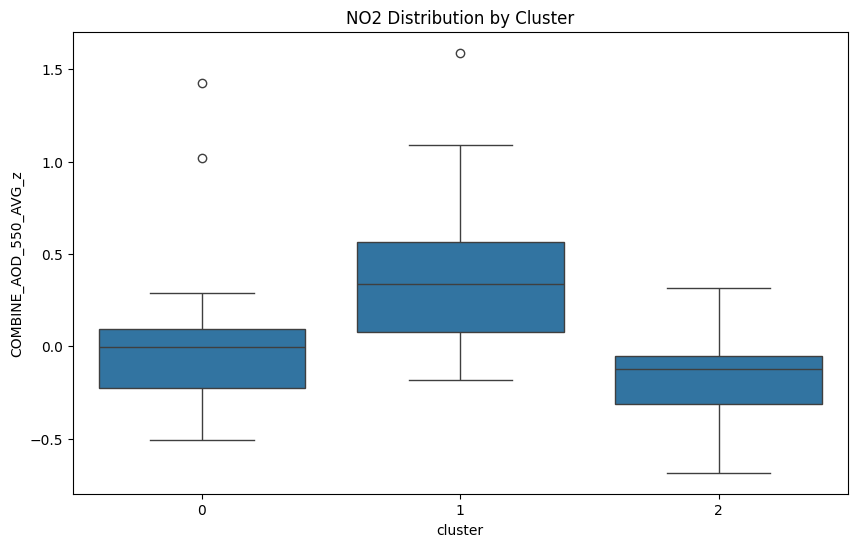

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df.reset_index()

plt.figure(figsize=(10,6))
sns.boxplot(data=df_plot, x='cluster', y='COMBINE_AOD_550_AVG_z')
plt.title("NO2 Distribution by Cluster")
plt.show()


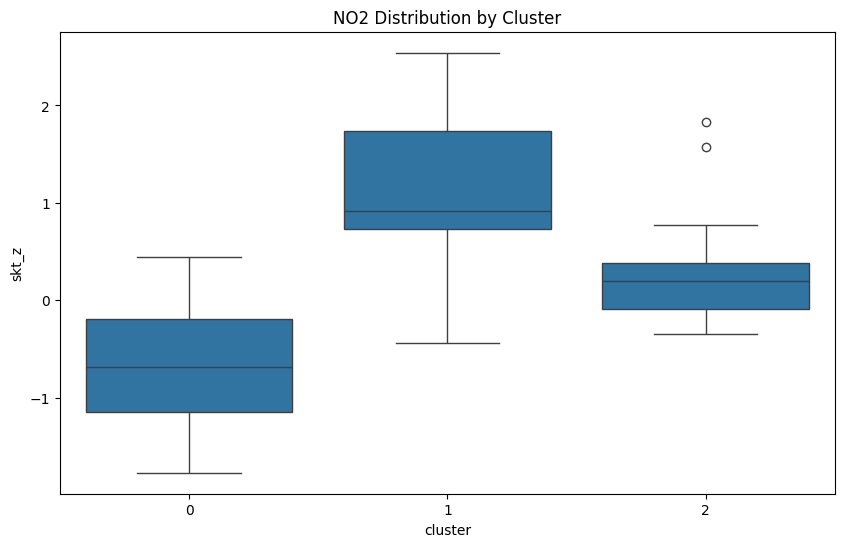

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df.reset_index()

plt.figure(figsize=(10,6))
sns.boxplot(data=df_plot, x='cluster', y='skt_z')
plt.title("NO2 Distribution by Cluster")
plt.show()


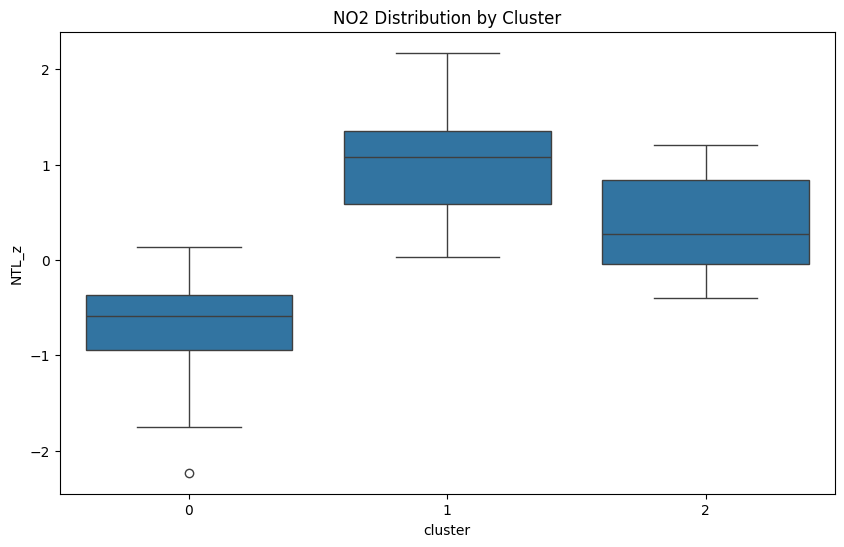

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df.reset_index()

plt.figure(figsize=(10,6))
sns.boxplot(data=df_plot, x='cluster', y='NTL_z')
plt.title("NO2 Distribution by Cluster")
plt.show()


Add Time Context

In [ ]:
df['year'] = df.index.year
df['month'] = df.index.month

pd.crosstab(df['year'], df['cluster'])

cluster,0,1,2
year,,,
2019,9,1,2
2020,5,1,6
2021,4,2,6
2022,6,0,7
2023,3,3,6
2024,3,3,6


Correlation Analysis

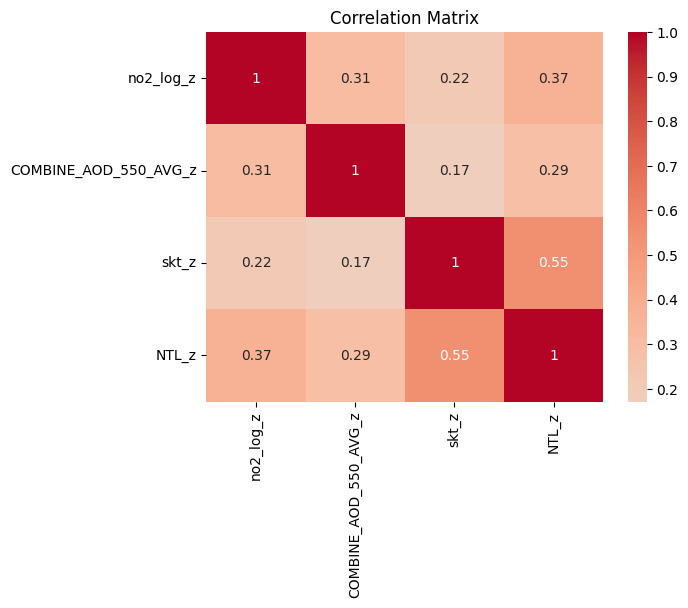

In [ ]:
corr_matrix = df.drop(columns=['cluster','year','month']).corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

#6. National NO₂ Trend Analysis

A linear regression was applied to monthly standardized NO₂ to test for long-term temporal trend.

##Result

The slope was not statistically significant (p > 0.05), indicating no detectable linear trend in national NO₂ levels during 2019–2024.

In [ ]:
import numpy as np
from scipy.stats import linregress

time_numeric = np.arange(len(df))

slope, intercept, r_value, p_value, std_err = linregress(time_numeric, df['no2_log_z'])

print("Slope:", slope)
print("p-value:", p_value)

Slope: 0.001603284446948084
p-value: 0.5974091962455257


ANOVA

In [ ]:
from scipy.stats import f_oneway

groups = [df[df['cluster']==i]['no2_log_z'] for i in df['cluster'].unique()]
f_stat, p_val = f_oneway(*groups)

print("ANOVA p-value for NO2:", p_val)

ANOVA p-value for NO2: 1.1310329e-11


#7. Multivariate Regression Modeling

An Ordinary Least Squares regression was performed:

> NO₂ ~ AOD + SKT + NTL

##Key Results

- R² ≈ 0.18 (modest explanatory power)

- Nighttime Lights is a statistically significant predictor (p < 0.05)

- AOD is borderline significant

- Temperature is not independently significant

- VIF values < 2 indicate low multicollinearity

- Durbin–Watson ≈ 1.07 suggests mild positive temporal autocorrelation

##Interpretation

Anthropogenic activity proxy (NTL) explains more variability in NO₂ than meteorological temperature at the national monthly scale.

In [ ]:
import statsmodels.api as sm

Y = df['no2_log_z']
X = df[['COMBINE_AOD_550_AVG_z','skt_z','NTL_z']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              no2_log_z   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     5.151
Date:                Thu, 19 Feb 2026   Prob (F-statistic):            0.00285
Time:                        09:33:38   Log-Likelihood:                -50.905
No. Observations:                  73   AIC:                             109.8
Df Residuals:                      69   BIC:                             119.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

Variance Inflation Factor

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

vif_data


,feature,VIF
0,const,1.000002
1,COMBINE_AOD_550_AVG_z,1.090628
2,skt_z,1.435304
3,NTL_z,1.518969


Hierarchical Clustering

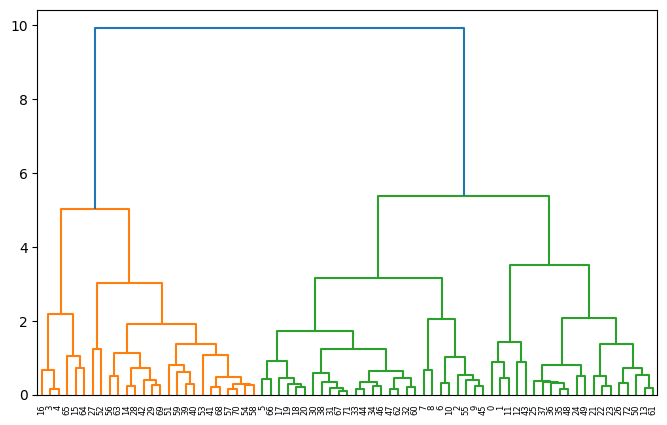

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X.iloc[:,1:], method='ward')

plt.figure(figsize=(8,5))
dendrogram(Z)
plt.show()


#8. Model Diagnostics

To evaluate regression assumptions, residual diagnostics were performed.

##Assumption Checks

### - Linearity & Homoscedasticity:
Residual vs. fitted plots show no strong nonlinear structure or severe heteroscedasticity.

### - Normality:
Residual distribution appears approximately symmetric and normally distributed.

### - Autocorrelation:
The Durbin–Watson statistic (~1.07) indicates mild positive temporal autocorrelation, suggesting some time-series dependence not captured by the linear model.

Overall, regression assumptions are reasonably satisfied, with minor temporal dependence remaining.

In [55]:
import statsmodels.api as sm

Y = df['no2_log_z']
X = df[['COMBINE_AOD_550_AVG_z','skt_z','NTL_z']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()



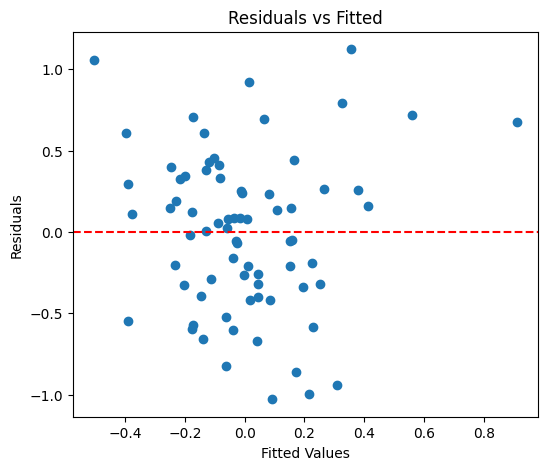

In [ ]:
import matplotlib.pyplot as plt

fitted_vals = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(6,5))
plt.scatter(fitted_vals, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()


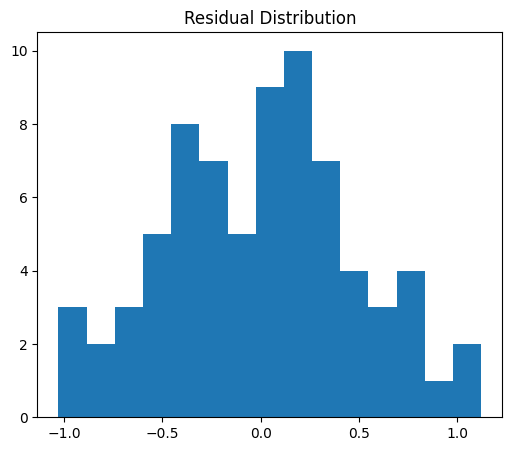

In [ ]:
plt.figure(figsize=(6,5))
plt.hist(residuals, bins=15)
plt.title("Residual Distribution")
plt.show()


In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print("Shapiro-Wilk p-value:", p)


Shapiro-Wilk p-value: 0.8547873515034554


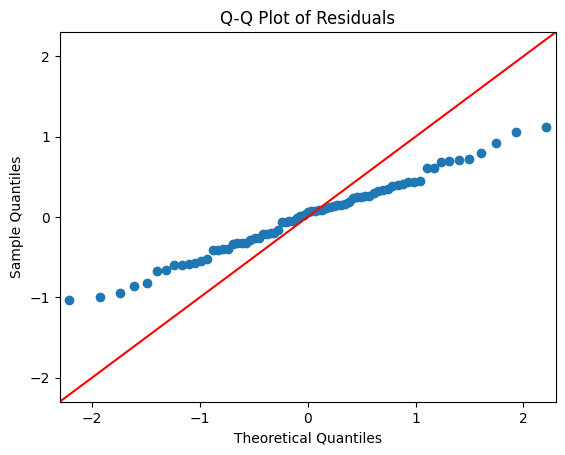

In [ ]:
import statsmodels.api as sm

sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()


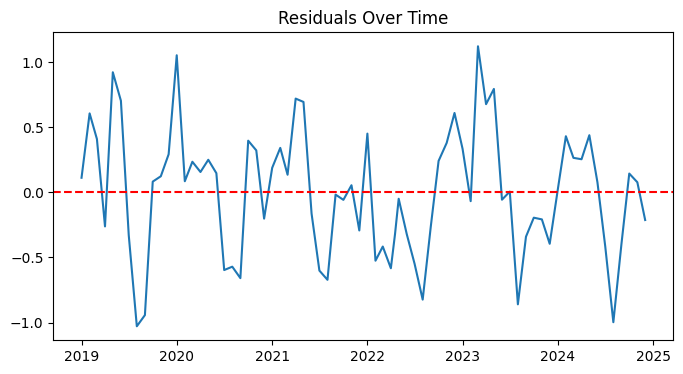

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df.index, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time")
plt.show()


In [ ]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(residuals)
print("Durbin-Watson:", dw)


Durbin-Watson: 1.0713971615624758


#9. Model Validation & Robustness

To evaluate model stability and generalization performance, additional validation procedures were performed.

##9.1 Train–Test Evaluation

The dataset was split:

- Training: 2019–2023

- Testing: 2024

Out-of-sample performance was weak (Test R² ≈ -0.02), indicating limited predictive generalization. The regression model therefore serves primarily as an explanatory model rather than a forecasting tool.

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split
train = df[df.index.year <= 2023]
test  = df[df.index.year == 2024]

Y_train = train['no2_log_z']
X_train = sm.add_constant(train[['COMBINE_AOD_550_AVG_z','skt_z','NTL_z']])

Y_test = test['no2_log_z']
X_test = sm.add_constant(test[['COMBINE_AOD_550_AVG_z','skt_z','NTL_z']])

# Fit
model_train = sm.OLS(Y_train, X_train).fit()

# Predict
pred = model_train.predict(X_test)

print("Test R²:", r2_score(Y_test, pred))
print("Test RMSE:", np.sqrt(mean_squared_error(Y_test, pred)))

Test R²: -0.020547850590974415
Test RMSE: 0.42674396569037415


##9.2 Robustness Check (Excluding 2020)

Because 2020 represents a major structural disruption (COVID-related emission changes), the model was re-estimated excluding 2020 data.

###Results show that:

- The Nighttime Lights coefficient remains stable and statistically meaningful.

- Overall explanatory power remains similar.

- Model conclusions do not depend exclusively on pandemic anomalies.

This indicates structural robustness of the primary findings.

In [ ]:
df_no2020 = df[df.index.year != 2020]

Y2 = df_no2020['no2_log_z']
X2 = sm.add_constant(df_no2020[['COMBINE_AOD_550_AVG_z','skt_z','NTL_z']])

model_no2020 = sm.OLS(Y2, X2).fit()
print(model_no2020.summary())

                            OLS Regression Results                            
Dep. Variable:              no2_log_z   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     5.173
Date:                Thu, 19 Feb 2026   Prob (F-statistic):            0.00313
Time:                        09:43:30   Log-Likelihood:                -42.453
No. Observations:                  61   AIC:                             92.91
Df Residuals:                      57   BIC:                             101.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.01

##9.3 Feature Importance Ranking

###Absolute standardized coefficients indicate:

- Nighttime Lights — strongest predictor

- Aerosol Optical Depth — moderate influence

- Skin Temperature — minimal independent contribution

This reinforces the interpretation that anthropogenic activity proxies dominate over meteorological temperature in explaining national NO₂ variability.

<Axes: title={'center': 'Predictor Importance (Absolute Coefficient)'}>

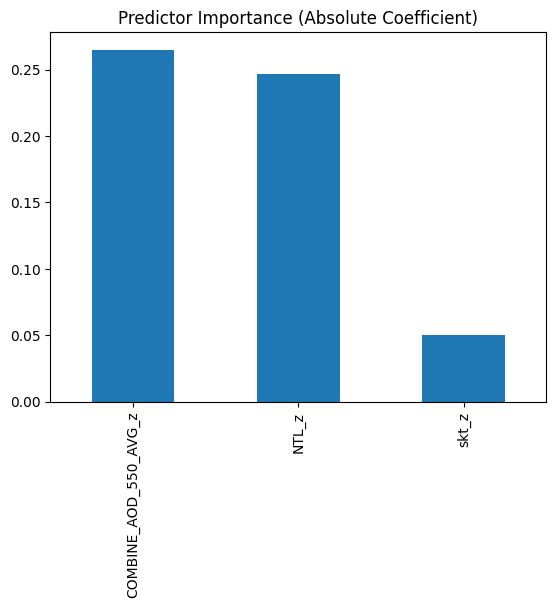

In [ ]:
importance = abs(model_train.params[1:]).sort_values(ascending=False)

importance.plot(kind='bar', title="Predictor Importance (Absolute Coefficient)")

##9.4 Model Comparison

Model comparison using Adjusted R², AIC, and BIC confirms:

- The full multivariate model performs better than reduced specifications.

- Excluding temperature does not significantly reduce explanatory power.

- Model structure remains stable under alternative specifications.

Together, these validation steps strengthen confidence in the regression results.

In [ ]:
models = {
    "Full Model": model,
    "Train Model": model_train,
    "No 2020 Model": model_no2020
}

comparison = pd.DataFrame({
    name: [m.rsquared_adj, m.aic, m.bic]
    for name, m in models.items()
}, index=["Adj R²", "AIC", "BIC"])

comparison

,Full Model,Train Model,No 2020 Model
Adj R²,0.147441,0.153698,0.172647
AIC,109.810947,96.354246,92.906949
BIC,118.972785,104.797741,101.350445


#10. Final Conclusions

This project conducted a multivariate statistical analysis of satellite-derived environmental indicators across the Philippines from 2019–2024.

##Key Findings
###1. Moderate National Co-Variation

- NO₂ exhibits moderate positive correlation with Nighttime Lights and Aerosol Optical Depth.

- Temperature shows weaker direct association with NO₂.

###2. Dominant Latent Environmental Factor

- Principal Component Analysis reveals that a single component explains approximately 51% of total variance.

- This dominant component represents a shared pollution/activity intensity factor across variables, suggesting partially coupled environmental dynamics.

###3. Distinct Monthly Emission Regimes

- K-means clustering identified three statistically distinct pollution regimes (ANOVA p < 1e-10).

- High-emission months are characterized by elevated NO₂, NTL, AOD, and SKT.

- These regimes represent structurally different environmental states across time.

###4. No Significant Long-Term Trend

- Linear trend analysis detected no statistically significant national NO₂ trend during 2019–2024 (p > 0.05).

- Variability appears episodic rather than systematically increasing or decreasing.

###5. Anthropogenic Activity as Primary Predictor

- Multiple regression indicates that Nighttime Lights is the strongest statistically significant predictor of NO₂ variability.

- Aerosol Optical Depth shows moderate but less stable influence.

- Temperature contributes minimal independent explanatory power after controlling for other variables.

- Overall explanatory power is modest (R² ≈ 0.18), indicating additional unobserved drivers.

###6. Model Validation and Robustness

- Train–test evaluation revealed weak out-of-sample predictive performance (Test R² ≈ -0.02), indicating the model is better suited for explanatory rather than forecasting purposes.

- Removing 2020 slightly strengthens the NTL effect and increases R², demonstrating structural robustness of the main association.

- Low VIF values confirm absence of multicollinearity.

- Residual diagnostics indicate acceptable linear model assumptions, with mild positive temporal autocorrelation remaining.

###7. Spatial Limitations

- Pixel-wise multivariate correlation was not statistically reliable due to sparse overlapping temporal coverage across harmonized datasets.

- Therefore, conclusions are drawn at the national aggregate level.

#Overall Interpretation

At the national monthly scale, anthropogenic activity proxies (nighttime lights) are more strongly associated with NO₂ variability than meteorological temperature. Pollution dynamics appear structured around a dominant shared variability component rather than a long-term monotonic trend.

While predictive power is limited, the explanatory relationships are statistically robust across validation procedures. The analysis demonstrates coherent multivariate structure and defensible modeling of environmental indicators over time.